# ICU Mortality Prediction
Uses data from the MIMIC eICU dataset. The goal is to predict whether patients will die while in the hospital, and the covariates are patient information, lab tests, vital signs, and exam findings. Here, the cost for each feature is 1, which means the optimization objective is simply to maximize predictive performance and limit the number of features in the model (i.e., sparsity).

The data require authorization but can be freely acquired from the [MIT Database](https://eicu-crd.mit.edu/gettingstarted/overview/). To run these experiments, place all `.csv` files from the eICU dataset in the `data/eicu` directory.

In [1]:
import pandas as pd
import numpy as np
import shap
import lightgbm as lgb
import sklearn
from sklearn import impute
from matplotlib import pyplot as plt
from tqdm import tqdm as tqdm
from collections import Counter
import itertools

from coai.knapsack import GreedyOptimizer, DynamicOptimizer, CoAIOptimizer
from coai.base import OneDimExplainer
from coai import cegb
from coai import plots

from get_qsofa_bp import load_bp

In [2]:
np.random.seed(100)

In [3]:
apsvar = pd.read_csv("../data/eicu/apacheApsVar.csv")
results = pd.read_csv("../data/eicu/apachePatientResult.csv")
predvar = pd.read_csv("../data/eicu/apachePredVar.csv")
patients = pd.read_csv("../data/eicu/patient.csv")
hospitals = pd.read_csv("../data/eicu/hospital.csv")

In [4]:
# Get outcomes
results = results.iloc[results['apacheversion'].values=='IVa']

# Get predictive variables (indexed by patient stay ID)
aps_id = apsvar.set_index('patientunitstayid')
predvar_id = predvar.set_index('patientunitstayid')
results_id = results.set_index('patientunitstayid')
patients_id = patients.set_index('patientunitstayid')

# All predictors in one DataFrame
all_pred = aps_id.join(predvar_id,how='outer',rsuffix='_aps')

# Drop duplicates
all_pred = all_pred.drop(columns=[c for c in all_pred.columns if '_aps' in c])

# All predictors and outcomes in one DataFrame
all_data = all_pred.join(results_id,how='inner',rsuffix='_results')
all_data = all_data.drop(columns=['apacheapsvarid','apachepredvarid','apachepatientresultsid'])

# Outcome of interest (mortality)
outcome = (all_data['actualhospitalmortality'].values=='EXPIRED').astype(int)

In [5]:
# Predictive variabels to be used as features
predvar_cols = ['intubated', 'vent', 'dialysis', 'eyes', 'motor', 'verbal', 'meds',
       'urine', 'wbc', 'temperature', 'respiratoryrate', 'sodium', 'heartrate',
       'meanbp', 'ph', 'hematocrit', 'creatinine', 'albumin', 'pao2', 'pco2',
       'bun', 'glucose', 'bilirubin', 'fio2', 'gender', 'bedcount',
       'admitsource', 'graftcount', 'age', 'admitdiagnosis', 'ventday1',
       'oobventday1', 'oobintubday1', 'diabetes', 'ejectfx', 'visitnumber',
       'amilocation', 'day1meds', 'day1verbal', 'day1motor', 'day1eyes',
       'day1pao2', 'day1fio2']
predvars = all_data[predvar_cols]

In [6]:
# Get hospitals
pt_hospitals = patients_id.loc[predvars.index,'hospitalid'].values
unique_hospitals = np.unique(pt_hospitals)

In [7]:
# Train/test split by hospital
unique_shuf = np.random.permutation(unique_hospitals)
nhosp = unique_hospitals.shape[0]
hosp_tv = np.random.permutation(hospitals['hospitalid'].iloc[np.isin(hospitals['region'].values,('Midwest','West','South'))].values)
hosp_train = hosp_tv[:int(0.8*len(hosp_tv))]
hosp_valid = hosp_tv[int(0.8*len(hosp_tv)):]
hosp_test = hospitals['hospitalid'].iloc[np.isin(hospitals['region'].values,('Northeast'))].values
train_inds = np.isin(pt_hospitals,hosp_train)
valid_inds = np.isin(pt_hospitals,hosp_valid)
test_inds = np.isin(pt_hospitals,hosp_test)

Xtrain, ytrain = predvars.iloc[train_inds],outcome[train_inds]
Xvalid, yvalid = predvars.iloc[valid_inds],outcome[valid_inds]
Xtest, ytest = predvars.iloc[test_inds],outcome[test_inds]

In [8]:
# Encode categorical features
for c in ['admitdiagnosis']:
    Xtrain[c] = Xtrain[c].astype('category')
    cats = Xtrain[c].cat.categories
    cat_type = pd.api.types.CategoricalDtype(categories=cats,ordered=False)
    Xvalid[c] = Xvalid[c].astype(cat_type)
    Xtest[c] = Xtest[c].astype(cat_type)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [9]:
Xtv = pd.concat([Xtrain,Xvalid])
ytv = np.hstack((ytrain,yvalid))

In [10]:
# APACHE IVa score
apachepreds = all_data.loc[Xtest.index]['predictedhospitalmortality'].values
# APACHE III score
apache3preds = all_data.loc[Xtest.index]['apachescore'].values
# APS score
apspreds = all_data.loc[Xtest.index]['acutephysiologyscore'].values

In [11]:
# Load processed BP data for qSOFA score
qsofa_bps = qbp = load_bp()
qbp_map = {ptid:val for ptid,val in qsofa_bps}

# Map to train/test inds
qbp_train = np.array([qbp_map[ptid] for ptid in Xtv.index])
qbp_test = np.array([qbp_map[ptid] for ptid in Xtest.index])

# Process NaNs
qbp_train[np.isnan(qbp_train)]=0
qbp_test[np.isnan(qbp_test)]=0

# qSOFA
qtrain = Xtv[['verbal','respiratoryrate','meanbp']].copy()
invtrain = qtrain<0
qtrain['verbal'] = Xtv[['verbal','motor','eyes']].sum(1)<15
qtrain['respiratoryrate'] = qtrain['respiratoryrate']>=22
qtrain[invtrain]=0
qtrain['meanbp'] = qbp_train
qtrain.columns = ['gcs','respiratoryrate','meanbp']

qtest = Xtest[['verbal','respiratoryrate','meanbp']].copy()
invtest = qtest<0
qtest['verbal'] = Xtest[['verbal','motor','eyes']].sum(1)<15
qtest['respiratoryrate'] = qtest['respiratoryrate']>=22
qtest[invtest]=0
qtest['meanbp'] = qbp_test
qtest.columns = ['gcs','respiratoryrate','meanbp']

qvars = ['verbal','motor','eyes']+['respiratoryrate','meanbp']

qimps = np.zeros(Xtrain.shape[1])
for i,v in enumerate(qvars[::-1]):
    qimps[np.where(Xtrain.columns==v)[0][0]]=i+1

Loading cached BP data...


In [12]:
# Gradient boosting parameters -- determined by cross-validation
gbm_params = {'learning_rate': 0.01, 'n_estimators': 1000, 'max_depth': 8, 'gamma': 1.0, 'min_child_weight': 10, 'subsample': 0.2, 'n_jobs': -1, 'verbosity': 0, 'silent': True, 'base_score': 0.08909925807489447}

In [13]:
GO = CoAIOptimizer(lgb.LGBMClassifier(**gbm_params),OneDimExplainer)
GO.fit(Xtrain,ytrain,np.ones(Xtrain.shape[1]))
GO.score_models_proba(Xtest,ytest,sklearn.metrics.roc_auc_score)
GO.explain_models()

Pass strategy=prior as keyword args. From version 0.25 passing these as positional arguments will result in an error
The default value of strategy will change from stratified to prior in 0.24.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
100%|██████████| 43/43 [06:17<00:00,  8.77s/it]
0it [00:00, ?it/s]Setting feature_perturbation = "tree_path_dependent" because no background data was given.
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
43it [19:19, 26.97s/it]


In [14]:
# CEGB = cegb.CEGBOptimizer(model=lgb.LGBMClassifier(**gbm_params),lambdas=np.logspace(-10,10,101))
# CEGB.fit(Xtrain,ytrain)
# CEGB.score_models_proba(Xtest,ytest,sklearn.metrics.roc_auc_score)
# CEGB.explain_models()

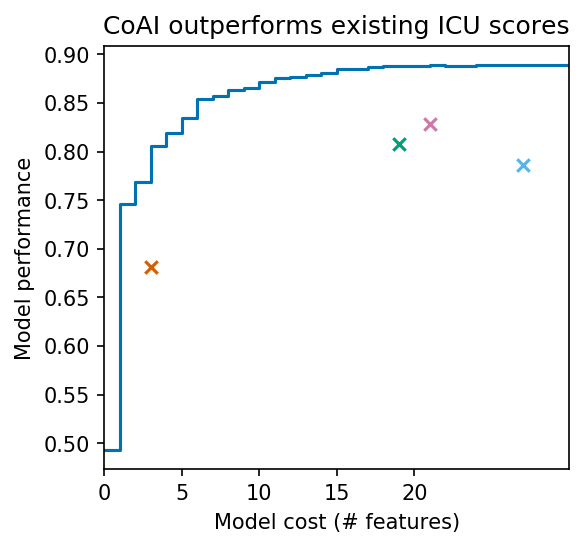

In [15]:
fig, axarr = plt.subplots(1,dpi=150,figsize=(4,3.75))
axarr = [axarr]

plots.cost_performance_curve(GO,ax=axarr[0], label=f'CoAI: {GO.auaucc(normalize=True,max_score=1.0):.4f}',color='#0072b2')
# plots.cost_performance_curve(CEGB,ax=axarr[0], label=f'CEGB: {CEGB.auaucc(normalize=True,max_score=1.0):.4f}')
axarr[0].scatter([27],[sklearn.metrics.roc_auc_score(ytest,apachepreds)],marker='x',label='APACHE IVa',color='#56B4E9')
axarr[0].scatter([19],[sklearn.metrics.roc_auc_score(ytest,apspreds)],marker='x',label='APS Score',color='#009E73')
axarr[0].scatter([21],[sklearn.metrics.roc_auc_score(ytest,apache3preds)],marker='x',label='APACHE III Score',color='#CC79A7')
# axarr[0].scatter([3],[sklearn.metrics.roc_auc_score(ytest,qmodel.predict_proba(qtest_ss)[:,1])],marker='x',label='qSOFA (continuous)',color='darkred')
axarr[0].scatter([3],[sklearn.metrics.roc_auc_score(ytest,np.sum(qtest,axis=1))],marker='x',label='qSOFA',color='#D55E00')
# axarr[0].scatter([6],[sscore],marker='x',label='SOFA',color='darkgreen')
# axarr[0].legend(loc='lower right')
axarr[0].set_xlabel('Model cost (# features)')
axarr[0].set_xlim(0,30)
axarr[0].set_xticks(np.arange(21)[::5])
axarr[0].set_title("CoAI outperforms existing ICU scores")
plt.tight_layout()

In [16]:
newcols = np.array(['Intub @ Worst ABG','Vent @ Worst RR','Dialysis','GCS Eyes','GCS Motor','GCS Verbal','Unscorable - Meds',
           'Urine','White Blood Cells','Temperature','Resp Rate','Sodium','Heart Rate',
           'Mean BP','pH','Hematocrit','Creatinine','Albumin','PaO2','PCO2','BUN','Glucose',
           'Bilirubin','fiO2',
           'Gender','Bed Count','Admit Source',' Graft Count','Age',
          'Admit Diagnosis', 'Vent @ Worst RR','Any Vent','Any Intub','Diabetes',
           'Ejection Fraction','Visit Number','MI Location','Unscorable - Meds','GCS Verbal',
          'GCS Motor','GCS Eyes','PaO2','FiO2'])

# newcols = np.array(['Intub @ Worst ABG','Vent @ Worst RR','Dialysis','Eyes','Motor','Verbal','Unscorable - Meds',
#            'Urine','White Blood Cells','Temperature','Resp Rate','Sodium','Heart Rate',
#            'Mean BP','pH','Hematocrit','Creatinine','Albumin','PaO2','PCO2','BUN','Glucose',
#            'Bilirubin','FiO2','Day in SICU','SAPS3 Day 1','SAPS3 Today','SAPS3 Yesterday',
#            'Gender','Teaching Type','Region','Bed Count','Admit Source',' Graft Count','Age',
#           'Admit Diagnosis', 'Vent @ Worst RR','Any Vent','Any Intub','Diabetes','Management System',
#            'Var03hspxlos','Ejection Fraction','Visit Number','MI Location','Unscorable - Meds','GCS Verbal',
#           'GCS Motor','GCS Eyes','PaO2','FiO2'])
# dropped_inds = np.isin(Xtrain.columns,['ventday1','day1meds', 'sicuday', 'saps3day1',
#        'saps3today', 'saps3yesterday','teachtype','region','managementsystem','var03hspxlos'])

In [17]:
# Feature importance for APACHE Score
# with open('../data/eicu/apache_coefs.txt') as f:
#     apache_coefs = {l.split(',')[0].strip():float(l.split(',')[1].strip()) for l in f}
# Feature importance for APACHE Score
with open('../data/eicu/apache_coefs_submission.txt') as f:
    apache_coefs = {l.split('\t')[0].strip():float(l.split('\t')[1].strip()) for l in f}
pred_coefs = np.array([apache_coefs[c] for c in Xtrain.columns])

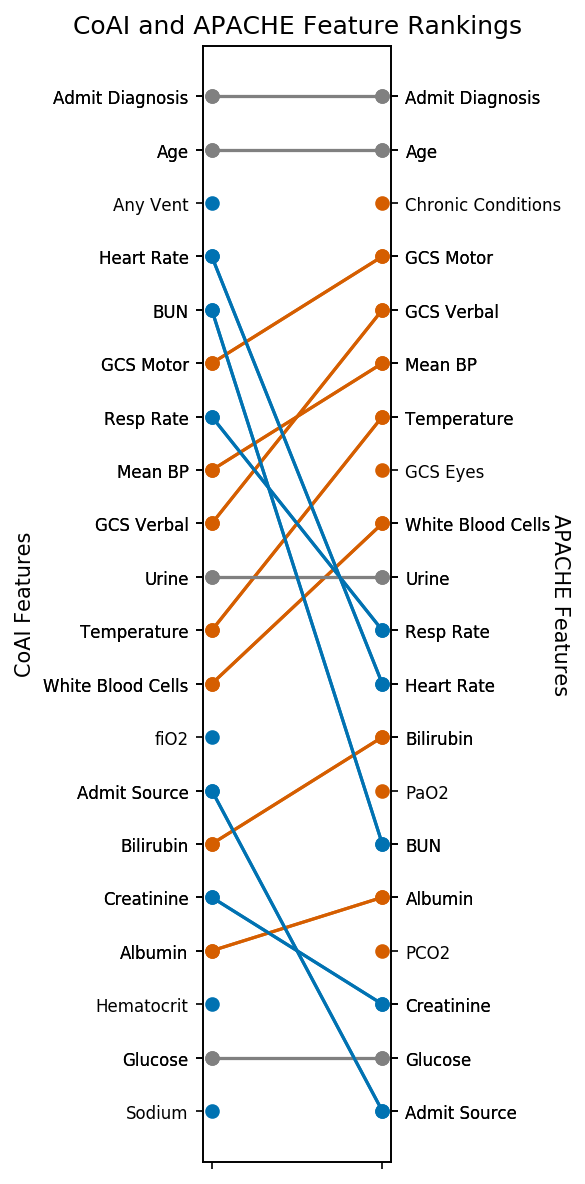

In [18]:
extra_vars = ['prevlos','chronichealth']
aug_newcols = np.hstack((newcols,['Pre-ICU Length of Stay','Chronic Conditions']))
pred_coefs3 = np.array([apache_coefs[k] for k in list(Xtrain.columns)+extra_vars])
apache_order = np.argsort(pred_coefs3)[::-1]
coai_icu_order = np.hstack((np.argsort(plots.first_feature_uses(GO)),np.arange(len(extra_vars))+GO.X.shape[1]))#[len(aug_newcols)]))
plt.figure(dpi=150,figsize=(4,8))
ax=plt.gca()
plots.compare_orders(
#     np.argsort(plots.first_feature_uses(GO)[~dropped_inds]),
#     np.argsort(pred_coefs[~dropped_inds])[::-1],
    coai_icu_order,apache_order,
    features=aug_newcols,ax=ax,min_per_model=20,max_per_model=20,model_names=['',''])
axt = plots.get_twin(ax)
ax.set_yticklabels(ax.get_yticklabels(),fontsize=8)
axt.set_yticklabels(axt.get_yticklabels(),fontsize=8)
ax.set_xticklabels(['',''])
ax.set_ylabel('CoAI Features')
twiny = axt.set_ylabel('APACHE Features')
twiny.set_rotation(-90)
plt.title("CoAI and APACHE Feature Rankings")
plt.tight_layout()

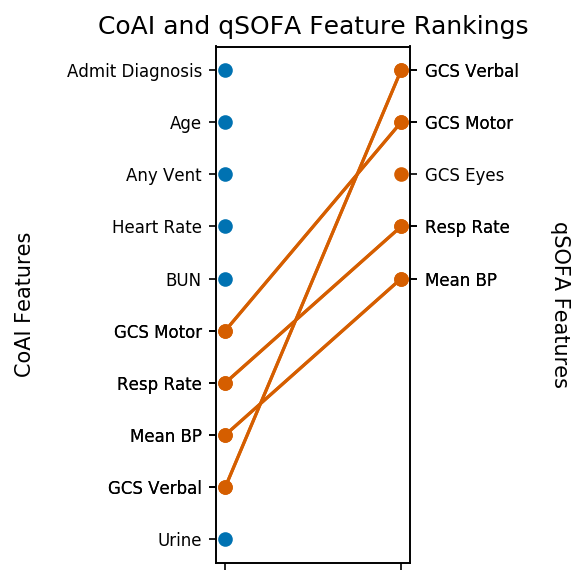

In [21]:
plt.figure(dpi=150,figsize=(4,4))
ax=plt.gca()
plots.compare_orders(
    np.argsort(plots.first_feature_uses(GO)),
    np.argsort(np.abs(qimps))[::-1],
    features=newcols,ax=ax,min_per_model=[10,5],max_per_model=[20,5],model_names=['CoAI','qSOFA'],
#     drop_bottom_k=30
)
axt = plots.get_twin(ax)
ax.set_yticklabels(ax.get_yticklabels(),fontsize=8)
axt.set_yticklabels(axt.get_yticklabels(),fontsize=8)
ax.set_xticklabels(['',''])
ax.set_ylabel('CoAI Features\n')
twiny = axt.set_ylabel('qSOFA Features\n',va='bottom')
twiny.set_rotation(-90)
plt.title("CoAI and qSOFA Feature Rankings")
plt.tight_layout()